In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
from astropy import units as u
import importlib
import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

import nustar_dem_prep as nu
import initial_analysis as ia
import orbit_auto as oa

importlib.reload(oa)

<module 'orbit_auto' from '/Users/jmdunca2/do-dem/orbit_auto.py'>

We want to split the data time interval into "suborbits" that each contain no correlator-identified pointing shifts, or SAAs. The idea is that a pointing correction (vs AIA) for one interval within the suborbit is good for the whole suborbit. There will be some times excluded: SAAs, and also some amount of time around NuSTAR pointing shifts. These non-sub-orbits should also be saved, for possible later use (analysis methods would be needed which are okay with the NuSTAR pointing being in-motion). 

There will be some minimum suborbit time for which we can make a useful DEM (i.e. sufficient NuSTAR statistics). This will depend on observation livetime, so we want to make sure it can be adjusted (see min_t below).  

FPMA and FPMB may have slightly different identified pointing shift times. Since we are adding data together in most cases, we need to make a unified list of good suborbits. To be conservative, we will only take times that both FPMA, B don't identify as being part of a pointing shift, etc. 

For each suborbit, we will: 
- run a form of the time interval selection code to find NuSTAR minimum time intervals and regions.
- find AIA regions: download a single AIA image per suborbit + coalign with NuSTAR


Pick your obsid directory, and make some decisions about time.

In [2]:
#id_dir = '/Users/jmdunca2/nustar/may-2018/80410202001/'
#id_dir = '/Users/jmdunca2/nustar/apr-2016/20101015001/'
id_dir = '/Users/jmdunca2/nustar/apr-2021/20615001001/'
obsid='20615001001'

#Name your working directory
working_dir='./initial_dem_apr21/'

#Make a new working directory for prepped data/etc if it doesn't yet exist
save_path = pathlib.Path(working_dir)
if not save_path.exists():
    save_path.mkdir()


#timestep for examining data (making correlator object)
t_corr = 2

#minimum length of suborbit
min_t = 15

#minimum number of steps needed in a sufficiently-sized suborbit, based on the above. 
min_step = int(np.ceil(min_t/t_corr))

We want to split the data time interval into "suborbits" that each contain no correlator-identified pointing shifts, or SAAs. 

There will be some minimum suborbit time for which we can make a useful DEM (i.e. sufficient NuSTAR statistics). This will depend on observation livetime, so we want to make sure it can be changed (via min_step keyword).

To do this we will create correlator objects for FPMB,A. This also will make correlator overview plots (saved), and make a good interval comparison plot. This takes about 3m the first time, and ~7s once you have saved your centroid files for each fpm.

Let's get sub-orbits! To combine FPMA, FPMB information, we select for only times where both FPM come out "good". 

d
Loading coordinates from pickle: ./centroid_coordinates/d_20615001001_fpmA_3s_RAW_centroid.pkl
d
Loading coordinates from pickle: ./centroid_coordinates/d_20615001001_fpmB_3s_RAW_centroid.pkl
2021-04-29 14:54:18.501558+00:00
2021-04-29 15:04:50.501558+00:00

2021-04-29 15:05:44.501558+00:00
2021-04-29 15:14:46.501558+00:00

2021-04-29 15:32:44.501558+00:00
2021-04-29 15:45:48.501558+00:00

2021-04-29 15:46:02.501558+00:00
2021-04-29 15:53:32.501558+00:00



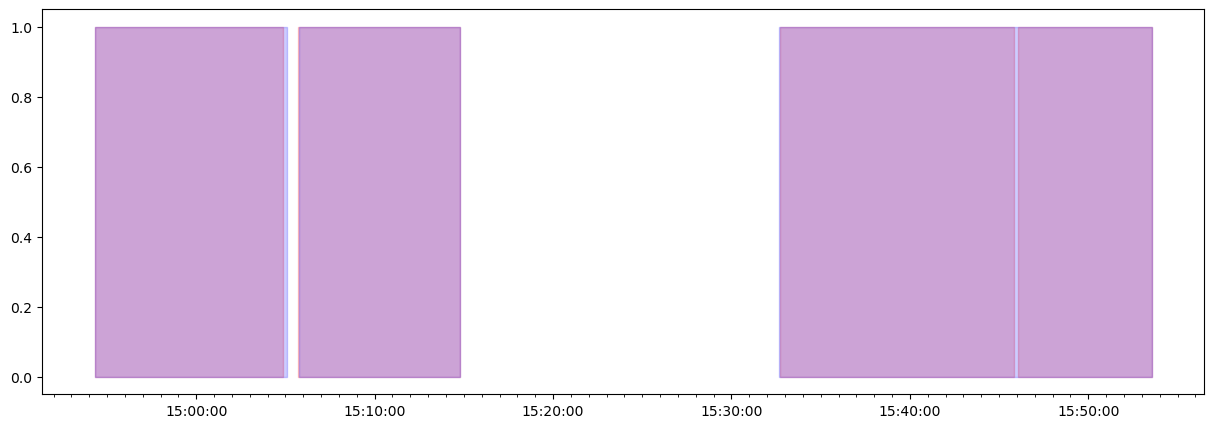

In [3]:
both_groupinds, both_grouptimes, bad_groups, bad_ids = oa.get_suborbits(id_dir, t_corr, min_step, plot=True)

Now, we want to take these suborbits and run time interval selection within each!

Options when finding intervals:

- __erange__ : set to highest energy range you want to use as a DEM input (higher energies = worse statistics)
- __countmin__: number of real counts you want in each DEM interval.
- __minimum_seconds__: set to a minimum duration for the DEM time intervals (optional, omit to not set a minimum). Effective minimum if not set is 5s (time binning of lightcurves). You could change this too by editing the lightcurve code. 
- __lctype__ : what kind of counts are you going to include? Options:
    
            'grade0' – grade 0 (FPMA,B sum)
            'grade04' - grade 0-4  (FPMA,B sum)
            'corr14' - grade 0 - (1/4)*grades 21-24 (FPMA, B sum)
            'corr54' - grade 0-4 - (5/4)*grades 21-24 (FPMA, B sum)
            
- __fast_min_factor__: factor multiplied by countmin when making an initial estimate of how long an interval is needed (fast method, without region selection). Accounts for the fact that some emission may fall outside the region. Adjust as needed; a larger factor will make this more time-efficient (less chance you'll make spectral data products for any too-small time intervals + have to repeat), but a smaller factor will get you closer to maximally-fine sampling in time.

Note on finding intervals: this is *slow* – it takes between 40 minutes to 3 hours on my machine for a single ~1 hr orbit, due to the need to make NuSTAR spectral data products for each interval. The brighter the source, the finer the time sampling, the longer it takes. But the spectral data products need to be made anyway to do DEMs, so it isn't a total waste. 

In [4]:
oa.get_suborbit_intervals(both_grouptimes, id_dir, working_dir, erange=[6.,10], force_both_fpm_always=True)    


Fast Method Counts:  20.0
2021-04-29 14:54:20+00:00
2021-04-29 14:59:05+00:00
ARF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.arf']
RMF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.rmf']
PHA File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.pha']
Using grades 0-4 NuSTAR events.
ARF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_4_p_sr.arf']
RMF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_4_p_sr.rmf']
PHA File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_4_p_sr.pha']
ARF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_21_24_p_sr.arf']
RMF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_21_24_p_sr.rmf']
PHA File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_21_24_p_sr.pha']

Max NuSTAR Energy:  18.399999618530273
Highest energy range: [6.0, 10]
Total Above:  1
Above Energies:  [18.39999962]
ATC: 8.25

ARF File:  [

Now that we've found time intervals for each sub-orbit, let's print them all to inspect, and also check what % of the total NuSTAR emission is in the region as a function of time. This is also a nice way to visualize the relative length of the different suborbits and time intervals within them.

0 - 0 14-54-20 14-59-05
0 - 1 14-59-05 15-02-25
0 - 2 15-02-25 15-03-40
0 - 3 15-03-40 15-04-10
0 - 4 15-04-10 15-04-50

1 - 0 15-05-45 15-07-00
1 - 1 15-07-00 15-08-00
1 - 2 15-08-00 15-09-05
1 - 3 15-09-05 15-09-35
1 - 4 15-09-35 15-10-05
1 - 5 15-10-05 15-10-35
1 - 6 15-10-35 15-11-05
1 - 7 15-11-05 15-12-25
1 - 8 15-12-25 15-14-45

2 - 0 15-32-45 15-33-20
2 - 1 15-33-20 15-34-00
2 - 2 15-34-00 15-34-30
2 - 3 15-34-30 15-35-10
2 - 4 15-35-10 15-35-40
2 - 5 15-35-40 15-36-10
2 - 6 15-36-10 15-36-40
2 - 7 15-36-40 15-38-45
2 - 8 15-38-45 15-39-50
2 - 9 15-39-50 15-40-45
2 - 10 15-40-45 15-42-35
2 - 11 15-42-35 15-44-55
2 - 12 15-44-55 15-45-45

3 - 0 15-46-05 15-46-35
3 - 1 15-46-35 15-47-05
3 - 2 15-47-05 15-47-55
3 - 3 15-47-55 15-49-35
3 - 4 15-49-35 15-53-30

Mean emision included:  86.02 %
Minimum emision included:  82.91 %
Maximum emision included:  89.01 %
STDV:  1.57 %


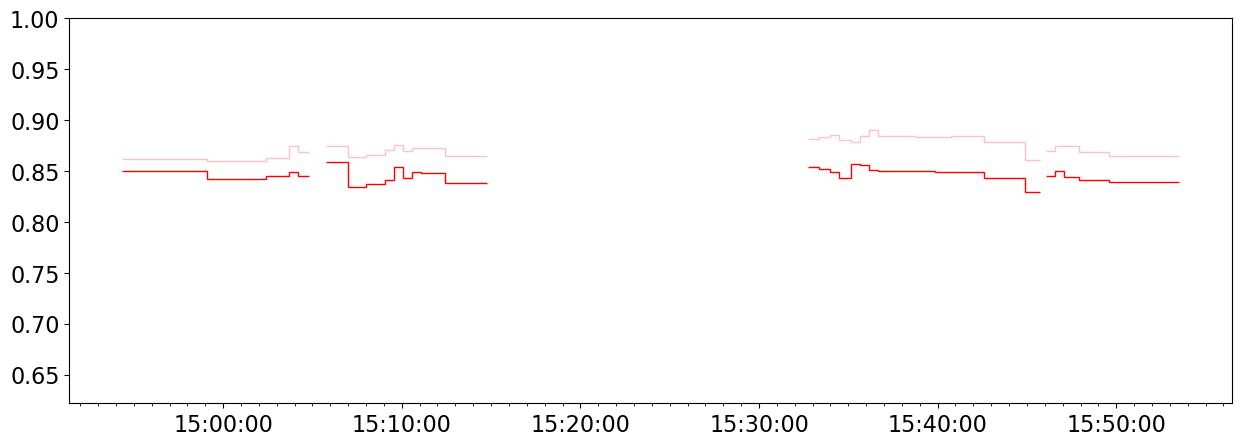

In [10]:
importlib.reload(oa)

all_time_intervals, all_time_intervals_list = oa.find_all_intervals(working_dir)

oa.check_region_emission(all_time_intervals, working_dir, grade='0_4', plot=True)

In order to do DEMs for each of these time intervals we will need to, for each suborbit, manually co-align NuSTAR and AIA to get an AIA region corresponding to the NuSTAR region. NOTE: currently, this ends up outputting the FPMB shifted region as the AIA region – worth thinking in the future about whether to do this separately for the FPM in some scenarios?

In [6]:
aiaregs = []

[{'radius': 150.0, 'centerx': <Quantity 790.21980049 arcsec>, 'centery': <Quantity -315.52286511 arcsec>}, {'radius': 150.0, 'centerx': <Quantity 776.13151924 arcsec>, 'centery': <Quantity -313.8415537 arcsec>}, {'radius': 150.0, 'centerx': <Quantity 786.15507217 arcsec>, 'centery': <Quantity -322.21699973 arcsec>}]
./initial_dem_apr21/15-46-05_15-46-35/nu20615001001A06_0_4_p_cl_sunpos.evt exists! Not re-making it.
Results from 1 Provider:

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time               End Time        Source Instrument  Wavelength  ... Extent Width Extent Length Extent Type   Size  
                                                                    Angstrom   ...                                         Mibyte 
----------------------- ----------------------- ------ ---------- ------------ ... ------------ ------------- ----------- --------
2021-04-29 15:46:11.000 2021-04-29 15:46:12.000  

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/jmdunca2/sunpy/data/aia_lev1_94a_2021_04_29t15_46_11_12z_image_lev1.fits']
./initial_dem_apr21/15-46-05_15-46-35/nu20615001001A06_0_4_p_cl_sunpos.evt exists! Not re-making it.
./initial_dem_apr21/15-46-05_15-46-35/nu20615001001B06_0_4_p_cl_sunpos.evt exists! Not re-making it.


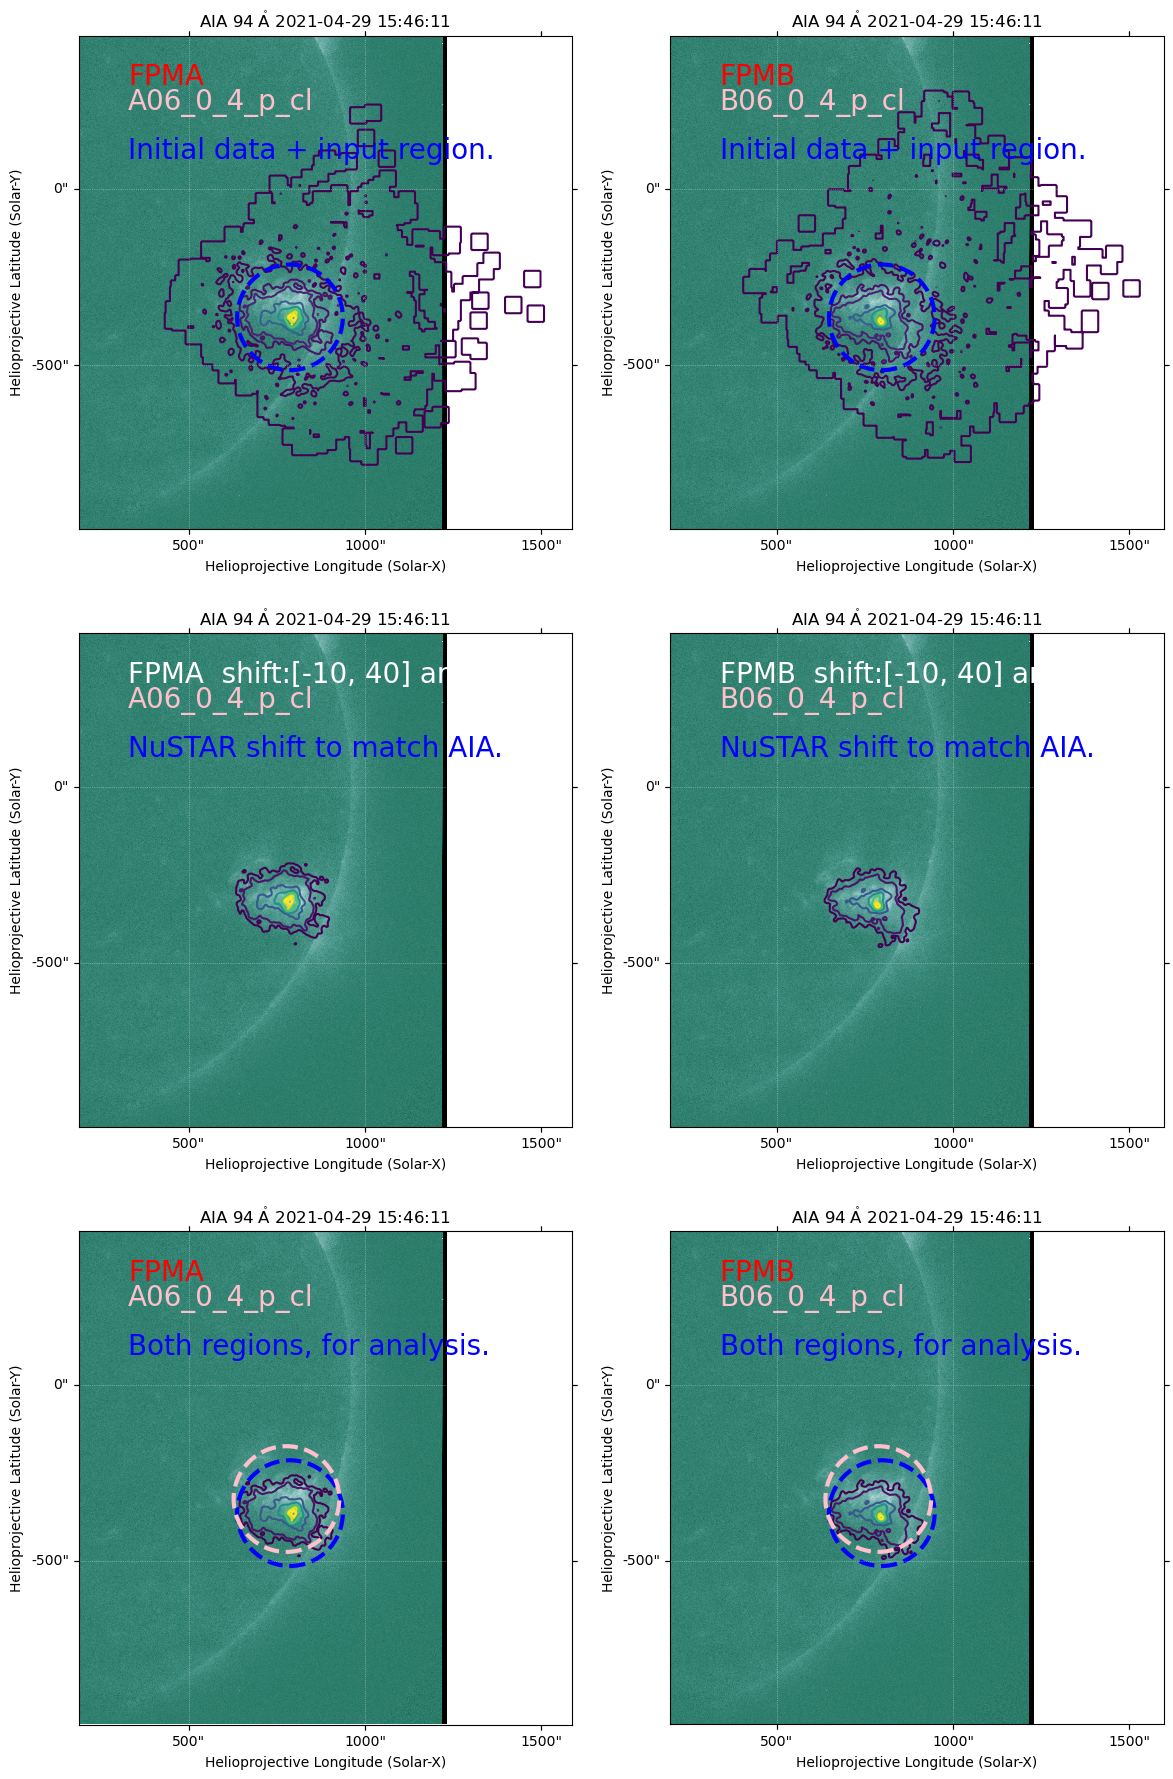

In [10]:
#Do one for each suborbit!
importlib.reload(oa)

print(aiaregs)

time_interval = all_time_intervals[0][0]
nushift=[60, 60]
#aiareg0, m = oa.nu_aia_coalign(time_interval, working_dir, nushift, id_dir)
#aiaregs.append(aiareg0)

time_interval = all_time_intervals[1][0]
nushift=[0, -130]
#aiareg1, m = oa.nu_aia_coalign(time_interval, working_dir, nushift, id_dir)
#aiaregs.append(aiareg1)

time_interval = all_time_intervals[2][0]
nushift=[60, 20]
#aiareg2, m = oa.nu_aia_coalign(time_interval, working_dir, nushift, id_dir)
#aiaregs.append(aiareg2)

time_interval = all_time_intervals[3][0]
nushift=[-10, 40]
aiareg3, m = oa.nu_aia_coalign(time_interval, working_dir, nushift, id_dir)
aiaregs.append(aiareg3)



In [11]:
#For each suborbit, make a bunch of saved files for every time interval containing the aia region
suborbit_directories = []
for at in range(0, len(all_time_intervals)):
    time = both_grouptimes[at]
    aiareg=aiaregs[at]
    
    timestring = time[0].strftime('%H-%M-%S')
    stopstring = time[1].strftime('%H-%M-%S')
    timestring=timestring+'_'+stopstring
    #suborbit directory
    suborbit_dir=working_dir+'suborbit_'+timestring
    suborbit_directories.append(suborbit_dir)
    #Make a new working directory for prepped data/etc if it doesn't yet exist
    save_path = pathlib.Path(suborbit_dir)
    if not save_path.exists():
        save_path.mkdir()
    
    
    oa.make_interval_dicts(all_time_intervals[at], aiareg, where=suborbit_dir)
    



Copy each of the below directories onto the NCCS, and then run AIA data prep for each. When done, re-copy them back for use in DEMs.

In [20]:
print(suborbit_directories)

['./initial_dem_apr21/suborbit_14-54-18_15-04-50', './initial_dem_apr21/suborbit_15-05-44_15-14-46', './initial_dem_apr21/suborbit_15-32-44_15-45-48', './initial_dem_apr21/suborbit_15-46-02_15-53-32']


In [5]:
#What instruments are you using?
#---------------------------------
aia=True
#---------------------------------
eis=False
xrt=False
#---------------------------------
plot=False
#---------------------------------
nustar=True
#If nustar is being used, here are the chosen energy ranges:
nuenergies=[[2.5,3.5],[3.5,6.], [6.,10.]]
#---------------------------------

#---------------------------------
#---------------------------------
#What temperature range would you like to use? (units: log(T))
minT=5.6
maxT=7.2

#Would you prefer to plot temperatures in MK, or the default (logT)
plotMK=False
#---------------------------------
#---------------------------------

name='initial_dem_apr21'

In [17]:
#AIA Error table - set path to location in your system.
#errortab='/Users/jmdunca2/ssw/sdo/aia/response/aia_V3_error_table.txt'

#Sunpy data directory (or wherever else you store your downloaded AIA data)
#sunpy_dir='/Users/jmdunca2/sunpy/data/'

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'

import dodem

importlib.reload(oa)

datapath=id_dir
gtifile=datapath+'event_cl/nu'+obsid+'A06_gti.fits'
regfile=path_to_dodem+'starter_region.reg'

suborbit_dir = working_dir+'/apr_21_suborbits/'

for time in all_time_intervals_list:

    #print(time)

    data, bl, tr = oa.read_interval_dicts(time, where=suborbit_dir, bltr=True)
    
    dodem.dodem(time, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                    plotMK=plotMK, minT=minT, maxT=maxT,
                                    plotresp=False, working_directory=working_dir,
                                    default_err=0.2, path_to_dodem=path_to_dodem,
            
                                    #demreg related
                                    rgt_fact=1.2, max_iter=30,
                                    reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
                                    #nustar related 
                                    combine_fpm=True, nuenergies=nuenergies, make_nustar=True, 
                                    datapath=datapath, gtifile=gtifile,
                                    COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
                                    #aia related
                                    load_prepped_aia=data)

[datetime.datetime(2021, 4, 29, 14, 54, 20)
 datetime.datetime(2021, 4, 29, 14, 59, 5)]
Start Time:  2021-04-29 14:54:20
Stop Time:  2021-04-29 14:59:05

ARF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.arf']
RMF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.rmf']
PHA File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001A06_0_p_sr.pha']

Max NuSTAR Energy:  6.119999885559082
ARF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001B06_0_p_sr.arf']
RMF File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001B06_0_p_sr.rmf']
PHA File:  ['./initial_dem_apr21/14-54-20_14-59-05/nu20615001001B06_0_p_sr.pha']

Max NuSTAR Energy:  24.119998931884766
Highest energy range: [6.0, 10.0]
Total Above:  1
Above Energies:  [24.11999893]

A94 :     3.44   0.69  20 %
A131 :     29.83   5.97  20 %
A171 :     598.15   119.63  20 %
A193 :     1161.48   232.30  20 %
A211 :     516.88   103.38  20 %
A335 :     26.21   5.24  20 %
2.5-3.5keV 

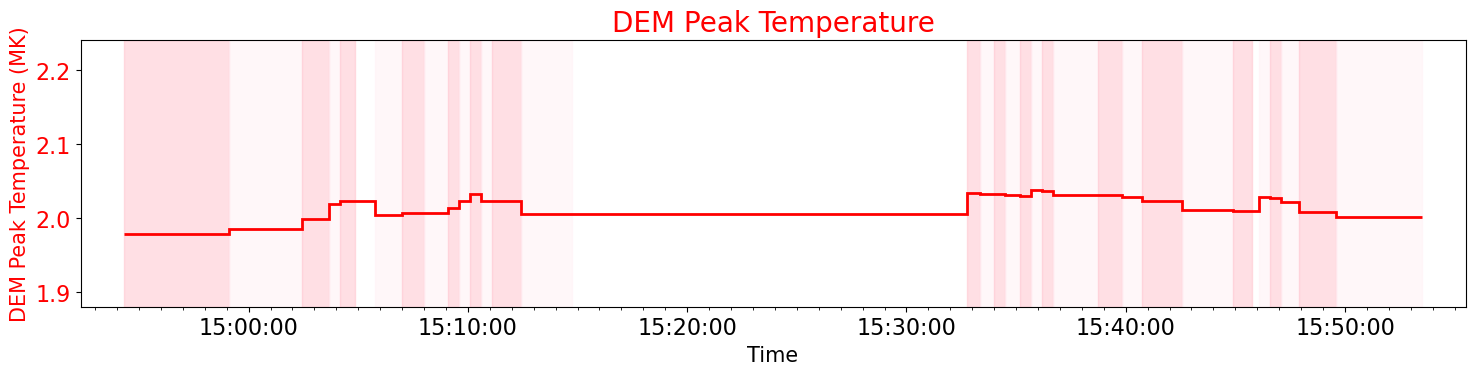

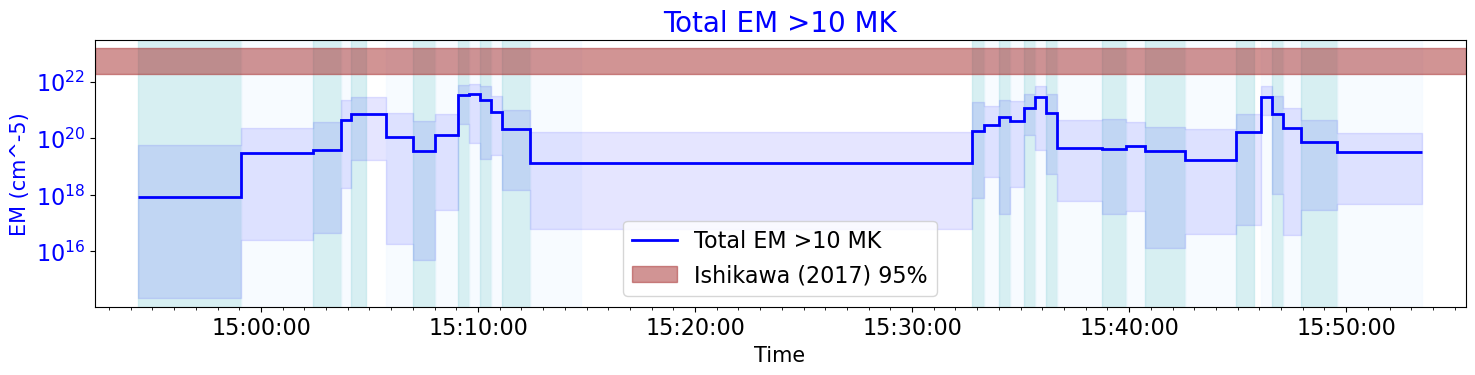

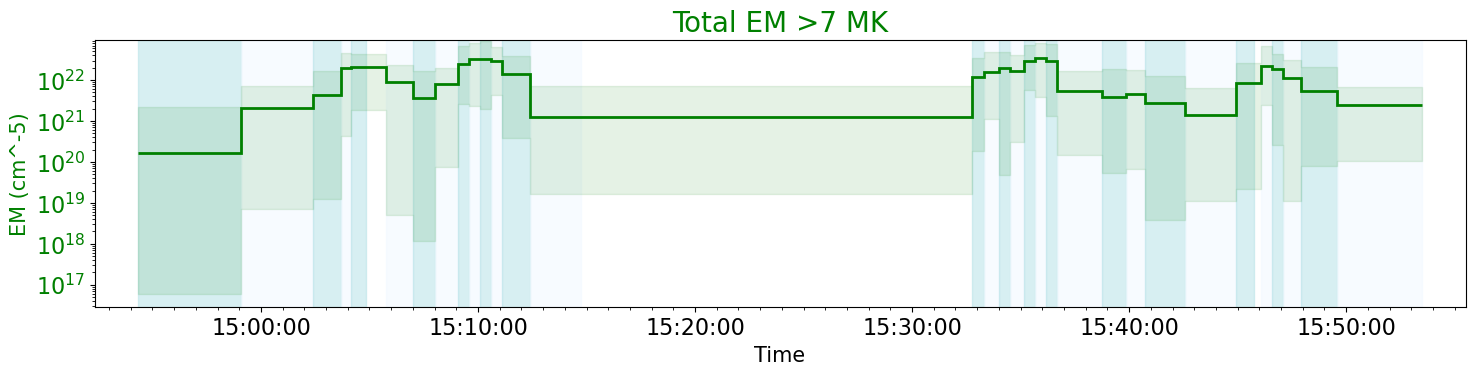

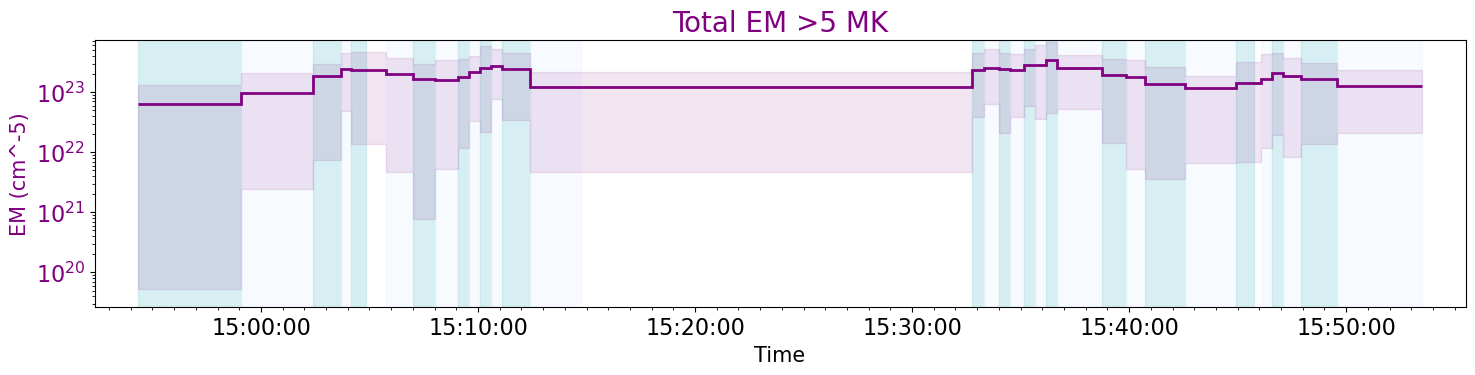

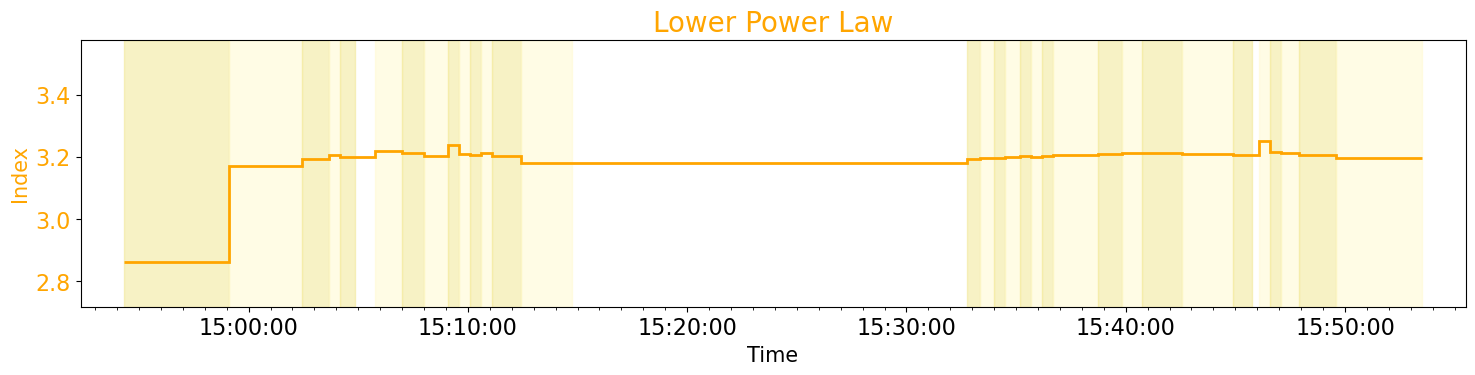

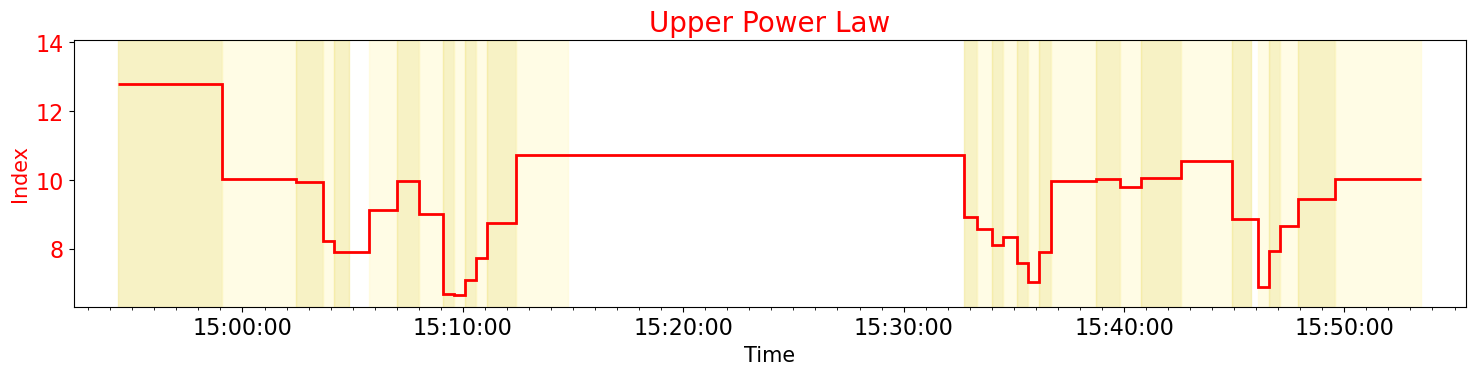

In [19]:
import visualize_dem_results as viz

time_intervals = all_time_intervals_list

importlib.reload(viz)
vals = viz.get_DEM_timeseries(time_intervals, working_dir, minT, maxT, name)    


peaks=vals['peaks']
peaksmk = [10**m1/1e6 for m1 in peaks]    

backcolors=['pink', 'lavenderblush']
color='Red'
    
viz.pretty_orbit_timeseries(time_intervals, peaksmk, 'DEM Peak Temperature (MK)', 'DEM Peak Temperature',
                        color, backcolors, working_dir=working_dir)


backcolors=['powderblue', 'aliceblue']
color='Blue'

above10s=np.array(vals['above10s'])
above10s_=above10s[:,0]

viz.pretty_orbit_timeseries(time_intervals, above10s_, 'EM (cm^-5)', 'Total EM >10 MK',
                        color, backcolors, error=True, quantity_low=above10s[:,1], quantity_high=above10s[:,2], 
                        ylog=True, comparisonbar=True, comp_band=[1.8e22, 1.5e23, 'Ishikawa (2017) 95%'],
                            working_dir=working_dir)

backcolors=['powderblue', 'aliceblue']
color='Green'

above7s=np.array(vals['above7s'])
above7s_=above7s[:,0]

viz.pretty_orbit_timeseries(time_intervals, above7s_, 'EM (cm^-5)', 'Total EM >7 MK',
                        color, backcolors, error=True, quantity_low=above7s[:,1], quantity_high=above7s[:,2], 
                        ylog=True, working_dir=working_dir)

backcolors=['powderblue', 'aliceblue']
color='Purple'

above5s=np.array(vals['above5s'])
above5s_=above5s[:,0]

viz.pretty_orbit_timeseries(time_intervals, above5s_, 'EM (cm^-5)', 'Total EM >5 MK',
                        color, backcolors, error=True, quantity_low=above5s[:,1], quantity_high=above5s[:,2], 
                        ylog=True, working_dir=working_dir)


backcolors=['khaki', 'lemonchiffon']
color='Orange'

val=np.array(vals['low_powers'])

viz.pretty_orbit_timeseries(time_intervals, val, 'Index', 'Lower Power Law',
                        color, backcolors, error=False, working_dir=working_dir)


backcolors=['khaki', 'lemonchiffon']
color='Red'

val=np.array(vals['hi_powers'])*-1

viz.pretty_orbit_timeseries(time_intervals, val, 'Index', 'Upper Power Law',
                        color, backcolors, error=False, working_dir=working_dir)



In [ ]:
#single DEM test


# #AIA Error table - set path to location in your system.
# errortab='/Users/jmdunca2/ssw/sdo/aia/response/aia_V3_error_table.txt'

# #Sunpy data directory (or wherever else you store your downloaded AIA data)
# sunpy_dir='/Users/jmdunca2/sunpy/data/'

# #Path to top-level do-dem directory - edit for your system.
# path_to_dodem = '/Users/jmdunca2/do-dem/'

# import dodem

# datapath=id_dir
# gtifile=datapath+'event_cl/nu'+obsid+'A06_gti.fits'
# regfile=path_to_dodem+'starter_region.reg'


# ind=0
# time = both_grouptimes[ind]
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# #suborbit directory
# suborbit_dir=working_dir+'/suborbit_'+timestring

# time_interval=time_intervals[0]
# data, bl, tr = read_interval_dicts(time_interval, where=suborbit_dir, bltr=True)


# importlib.reload(dodem)
# #NuSTAR and AIA DEM
# dodem.dodem(time_interval, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
#                                     plotMK=plotMK, minT=minT, maxT=maxT,
#                                     plotresp=False, working_directory=working_dir,
#                                     default_err=0.2, path_to_dodem=path_to_dodem,
            
#                                     #demreg related
#                                     rgt_fact=1.2, max_iter=30,
#                                     reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
#                                     #nustar related 
#                                     combine_fpm=True, nuenergies=nuenergies, make_nustar=True, 
#                                     datapath=datapath, gtifile=gtifile,
#                                     COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
#                                     #aia related
#                                     load_prepped_aia=data)
